# 03 Response surfaces

One fruitful application that employs the existence of an Active Subspace is the design of response surfaces, see [Constantine, Paul G. active subspaces: emerging ideas for dimension reduction in parameter studies](https://doi.org/10.1137/1.9781611973860). In particular we will build response surfaces with Gaussian process regression. 

We will show the better results obtained by the optimal profile that theoretically establishes the optimal a priori estimate of the root mean square error on the ridge approximation, see also [Zahm, Olivier, Paul G. Constantine, Clementine Prieur, and Youssef M. Marzouk. "Gradient-based dimension reduction of multivariate vector-valued functions."](https://epubs.siam.org/doi/pdf/10.1137/18M1221837).

To have a clear view on the procedure the following are the approximations involved

$$\large
f(\mathbf{X}) \approx g_{\epsilon, \omega}(\mathbf{W}_1\mathbf{X})\approx
    \hat{g}_{\epsilon, \omega, M}(\hat{\mathbf{W}}_1\mathbf{X})\approx
    \mathscr{R}_{\epsilon,\omega,M,\delta}(\hat{\mathbf{W}}_1\mathbf{X}), 
$$

1. approximation with the exact optimal profile and exact gradients $g_{\epsilon, \omega}=\mathbb{E}_{\rho}[f|\mathbf{W}_{1}\mathbf{X}]$
2. approximation of the correlation matrix $\mathbf{C}$ with Monte Carlo and use of approximated gradients: $g_{\epsilon, M, \omega}(\hat{\mathbf{W}}_1\mathbf{X})$
3. regression with Gaussian processes: $\mathscr{R}_{\epsilon,\omega,M,\delta}(\hat{\mathbf{W}}_1\mathbf{X})$

The library we use for Gaussian process regression is [GPy](https://github.com/SheffieldML/GPy) and for Hamiltonian Monte Carlo [pyhmc](https://github.com/rmcgibbo/pyhmc).

In [68]:
import autograd.numpy as np
from autograd import elementwise_grad as egrad
import matplotlib.pyplot as plt
from functools import partial

import GPy
from pyhmc import hmc
from queue import Queue
from threading import Thread
import timeit

from athena.active import ActiveSubspaces
from athena.utils import Normalizer

from data.numpy_functions import sin_2d, radial

import warnings
warnings.filterwarnings('ignore')

In [69]:
np.random.seed(42)

# Global parameters
n_samples = 50
input_dim = 5

In [70]:
# Uniformly distributed inputs
lb = 0 * np.ones(input_dim)
ub = 2 * np.ones(input_dim)

def inputs_uniform(n_samples, n_pars, lb,  ub):
    return np.vstack(
        np.array([np.random.uniform(lb[i], ub[i], n_samples) for i in range(n_pars)]).T)

In [71]:
# Gaussian model for the inputs
mean = np.ones(input_dim)
cov = 0.5*np.diag(np.ones(input_dim))

def inputs_gaussian(n_samples, mean, cov):
    return np.random.multivariate_normal(mean, cov, n_samples)

The model of interest is an hyperparaboloid. We define also the optimal profile $\mathbb{E}_{\rho}[f|W_{1}^{T}\mathbf{X}]$ that will be used instead of the model $f(W_{1}^{T}\mathbf{X})$ achieving the theoretical optimal a priori estiamte.

In [72]:
def generatrix(x):
    return x

def output(x, normalizer, r):
    return r(np.linalg.norm(normalizer.inverse_transform(x)**2, axis=1)**2)

def profile(active, ss, f_out, N=10):
    return (1/N)*np.sum(np.array([f_out(ss.inverse_transform(active)[0]) for i in range(N)]), axis=0)

In [73]:
# Generate and normalize inputs
X = inputs_uniform(n_samples, input_dim, lb, ub) #X = inputs_gaussian(M, mean, cov)
nor = Normalizer(lb, ub)
x = nor.fit_transform(X)

# Define the output of interest and compute the gradients
func = partial(output, normalizer=nor, r=generatrix)
f = func(x)
df = egrad(func)(x)

We compute the active subspace and use the method ActiveSubspaces.backward to approximate with Monte Carlo the optimal profile 

$$\mathbb{E}_{\rho}[f|W_{1}^{T}\mathbf{X}]\approx\frac{1}{N}\sum_{i=1}^{N}f(W_{1}Y+W_{2}\mathbf{Z}_{i})$$

where $\mathbf{Y}=W_{1}^{T}\mathbf{X}$ and $\mathbf{Z}=W_{2}^{T}\mathbf{X}$ are the active and inactive variables respectively. The optimal profile depends only on the variables $\mathbf{Y}$ while the inactive ones are sampled from the conditional distribution $p(\mathbf{z}|\mathbf{y})$: this is done with importance sampling inside athena, but is implemented only for the uniform distirbution. For a more general distribution we will use Hamiltonian Monte Carlo.

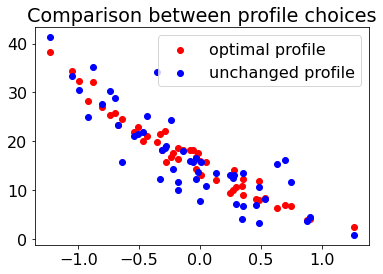

In [74]:
# Compute the active subspace
asub = ActiveSubspaces(dim=1)
asub.fit(gradients=df)

M_test = 50
X_test = inputs_uniform(M_test, input_dim, lb, ub)
nor = Normalizer(lb, ub)
x_test = nor.fit_transform(X_test)
f_test = func(x_test)
x_forward = asub.transform(x_test)[0]
g = profile(x_forward, asub, func)
plt.scatter(x_forward, g, c='r', label='optimal profile')
plt.scatter(x_forward, f_test, c='b', label='unchanged profile')
plt.legend()
plt.title('Comparison between profile choices')
plt.show()

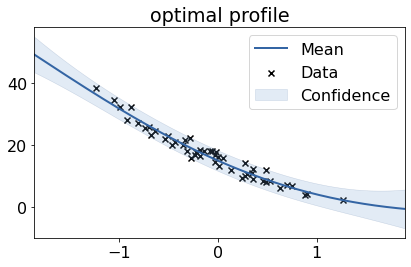

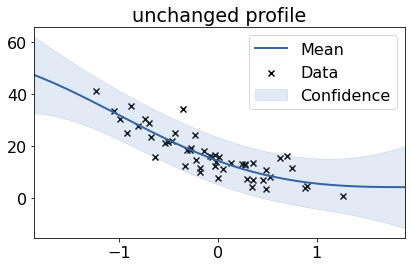

Relative Root Mean Square Error for optimal profile 11.369%
Relative Root Mean Square Error for unchanged profile 31.348%


In [75]:
gp_g = GPy.models.GPRegression(x_forward, g.reshape(-1, 1))
gp_f = GPy.models.GPRegression(x_forward, f_test.reshape(-1, 1))

gp_g.constrain_positive('')
gp_g.optimize_restarts(5, verbose=False)

gp_f.constrain_positive('')
gp_f.optimize_restarts(5, verbose=False)

y_g = gp_g.predict(x_forward)[0]
y_f = gp_f.predict(x_forward)[0]

gp_g.plot(title="optimal profile")
gp_f.plot(title="unchanged profile")

plt.show()

def RRMSE(test, true):
    return np.sqrt(np.sum((test.reshape(-1) - true.reshape(-1))**2) )#/ np.sum((true - true.mean())**2))

print("Relative Root Mean Square Error for optimal profile {:.3f}%".format(RRMSE(y_g, g)))
print("Relative Root Mean Square Error for unchanged profile {:.3f}%".format(RRMSE(y_f, f_test)))

### Remarks

Try to change the output of interest. What is the effect of choosing the optimal profile from the practical point of view of building a response surface?

# Response surfaces with HMC

A part from the uniform distribution for which an importance sampling algorithm is efficient to sample from the conditional distribution $p(z|y)$, in the general case sampling can be achieved with more advanced methods like Hamiltonian Monte Carlo.

In the following case we consider the inputs distributed according to the probability density function

$$\large
p(y, z) \propto \exp\left(-\frac{1}{20}\left(\lVert \mathbf{W}_{1}y+\mathbf{W}_{2}z- 5c\rVert^{2}_{2}\right)-\frac{1}{20}\left(\lVert \mathbf{W}_{1}y+\mathbf{W}_{2}z- c\rVert^{2}_{2}\right)\right)
$$

where $c$ is a constant vector with the same dimension of the input space and ones as components.

In [76]:
# Global parameters
n_samples = 500
input_dim = 2

In [77]:
# logarithm of the probability density p(x)=p(y, z)
def log_proposal(x, V):
    dV = egrad(V)
    return V(x), dV(x)


# logarithm of the conditional probability density p(z|y)
def log_inactive_con_active(z, y, ss, V):
    func_z = lambda z_: V(ss.W1 * y + ss.W2 * z_)
    dfunc_z = egrad(func_z)
    return func_z(z), dfunc_z(z)

# optimal profile
def profile(active, ss, f_out, N=10):
    """
    Optimal profile of AS ridge approximation.
    :param ndarray active: active variables at which the optimal profile will be queried at
    :param ActiveSubspace ss: active subspaces of output of interest
    :param function f_out: output of interest
    :param int N: number of Monte Carlo samples
    :rtype: ndarray
    """
    y = np.array([active])
    pr_args = (y, ss, V)
    inactive = chains(log_inactive_con_active,
                      1,
                      n_samples=N,
                      epsilon=0.2,
                      pr_args=pr_args,
                      dim=1,
                      n_burn=100)
    x = np.hstack((y * np.ones((10, 1)), inactive)).dot(ss.evects.T)
    return (1 / N) * np.sum(f_out(x))

In [78]:
# Potential
V = lambda x_: -(0.5 * (1 / 10) * np.linalg.norm(x_ - 5*np.ones([input_dim]))**2
                 ) - 0.5 * (1 / 10) * np.linalg.norm(x_ - 1*np.ones([input_dim]))**2

Parallel implementation of sampling procedure with hmc.

In [79]:
def chains(proposal, N, **kwargs):
    """
    Sample from log probability density function proposal,
    with N threads.
    """
    q = Queue()
    threads = []
    thread_ind(proposal, N, q, threads, kwargs)

    for t in threads:
        t.join()

    results = []
    while True:
        if not q.empty():
            results.append(q.get())
        else:
            break
    return np.vstack(results)

def thread_ind(proposal, N, q, threads, kwargs):
    for i in range(N):
        t = Thread(target=func_thread, args=(proposal, q), kwargs=kwargs)
        t.start()
        threads.append(t)
        
def func_thread(proposal, queue, **kwargs):
    """
    Sample from log probability density function proposal with pyhmc,
    see https://github.com/rmcgibbo/pyhmc for tutorials.
    """
    res = hmc(proposal,
              args=(*kwargs['pr_args'], ),
              x0=np.random.randn(kwargs['dim']) + 1.5 * np.ones(kwargs['dim']),
              n_samples=kwargs['n_samples'],
              display=False,
              n_steps=40,
              n_burn=kwargs['n_burn'],
              epsilon=kwargs['epsilon'],
              return_diagnostics=True)
    queue.put(res[0])

Sample inputs from $p(x)\sim\exp(-V(x))$ in parallel.

In [80]:
t3 = timeit.default_timer()
X = chains(log_proposal,
           1,
           n_samples=1000,
           epsilon=0.1,
           pr_args=(V, ),
           dim=input_dim,
           n_burn=1000)
print("timer {} s".format(timeit.default_timer() - t3))

timer 25.08873469000173 s


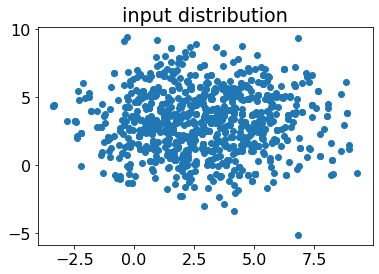

In [81]:
plt.scatter(X[:, 0], X[:, 1])
plt.title("input distribution")
plt.show()

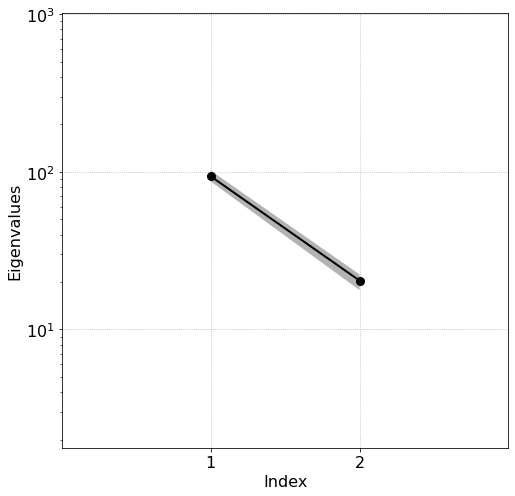

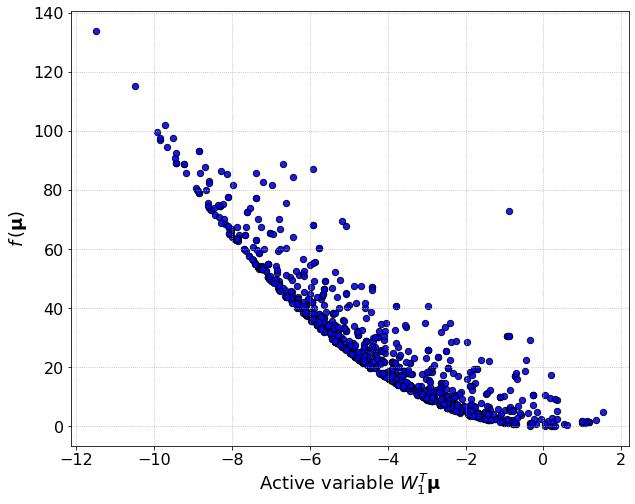

In [82]:
# Define the output of interest and compute the gradients
func = partial(radial, normalizer=None, generatrix=lambda x: x)
f = func(X)
df = egrad(func)(X)

# Compute the active subspace
asub = ActiveSubspaces(dim=1)
asub.fit(gradients=df)
asub.plot_eigenvalues()
asub.plot_sufficient_summary(X, f)

Use again parallel implementation of hmc sampling to compute the outputs of the optimal profile $g$ at the active components of the inputs X_test.

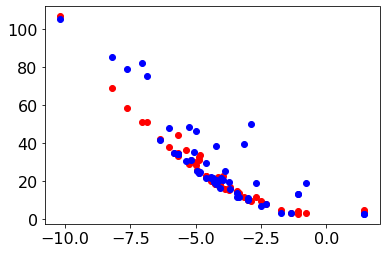

In [83]:
M_test = 60
X_test = chains(log_proposal,
                2,
                n_samples=30,
                epsilon=0.2,
                pr_args=(V, ),
                dim=2,
                n_burn=300)
f_test = func(X_test)
x_forward = asub.transform(X_test)[0]
optimal_profile = np.array([profile(x_forward[i, :], asub, func) for i in range(M_test)])
plt.scatter(x_forward, optimal_profile, c='r')
plt.scatter(x_forward, f_test, c='b')
plt.show()

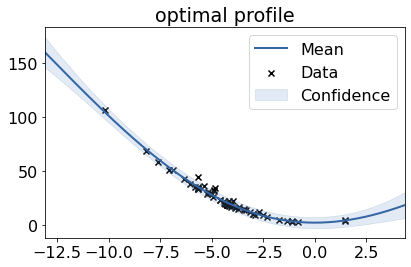

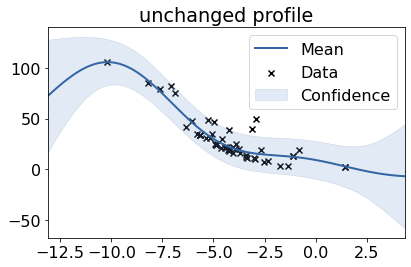

Relative Root Mean Square Error for optimal profile 18.530%
Relative Root Mean Square Error for unchanged profile 63.634%


In [84]:
gp_g = GPy.models.GPRegression(x_forward, optimal_profile.reshape(-1, 1))
gp_f = GPy.models.GPRegression(x_forward, f_test.reshape(-1, 1))

gp_g.constrain_positive('')
gp_g.optimize_restarts(15, verbose=False)

gp_f.constrain_positive('')
gp_f.optimize_restarts(15, verbose=False)

gp_g.plot(title="optimal profile")
gp_f.plot(title="unchanged profile")
plt.show()

y_g = gp_g.predict(x_forward)[0]
y_f = gp_f.predict(x_forward)[0]

def RRMSE(test, true):
    return np.sqrt(np.sum((test.reshape(-1) - true.reshape(-1))**2) )#/ np.sum((true - true.mean())**2))

print("Relative Root Mean Square Error for optimal profile {:.3f}%".format(RRMSE(y_g, optimal_profile)))
print("Relative Root Mean Square Error for unchanged profile {:.3f}%".format(RRMSE(y_f, f_test)))

### Remarks

Try changing the potential V i.e. the probability density function $p(y,z)$ in order to study different input distributions.